In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import functools
import community

from scipy import sparse
from scipy.sparse import linalg
import time
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from math import sqrt
import pandas as pd
from shapely.ops import cascaded_union
pd.set_option('precision', 10)

# Functions

# Natural Roads

In [70]:
lineA = ((530002.0437683944, 180335.6595889045),(530035.6433684696, 180384.0141889125))
lineB = ((530035.6433684696, 180384.0141889125),(529973.0037684409, 180388.919588969))
ang(lineA, lineB)

120.3160507267586

In [18]:
def natural_road(current_id, natural_id, direction):
        
    if (current_id ==0): #select a new road
        to_process = list(set(segments) - set(processed))
        to_process.sort()

        current_id = to_process[0]
        natural_id = counter+1
    else:
        natural_id = natural_id 
     
    angles = {}
    directions_dict = {}
    to_node = result.loc[current_id]['u']
    from_node = result.loc[current_id]['v']             
 
    x_t = float("{0:.10f}".format(nodes_geo.loc[to_node]['x']))
    y_t = float("{0:.10f}".format(nodes_geo.loc[to_node]['y']))
    x_f = float("{0:.10f}".format(nodes_geo.loc[from_node]['x']))
    y_f = float("{0:.10f}".format(nodes_geo.loc[from_node]['y']))
            
    if (direction == "to"): #continue from the to_node
        intersecting = result[(result['u']==to_node) | (result['v']==to_node)]
    elif (direction == "fr"): #continue from the from_node
        intersecting = result[(result['u']==from_node) | (result['v']==from_node)]
    else: #if direction doesn't matter:check everything  
        intersecting = result[(result['u']==to_node) | 
                                (result['v']==to_node) |
                                (result['u']==from_node) |
                                (result['v']==from_node)]
        
    ## No interesecting roads (it shouldn't happen)
    if (len(intersecting)==0): 
        processed.append(current_id)
        result.set_value(current_id, 'natural_id', natural_id)
        #recall the function
        natural_road(current_id=0, natural_id=natural_id, direction="zero")
        
    # otherwise, for each intersecting road, that hasn't been processed yet, compute the deflection angle
    else:
        for index, row in intersecting.iterrows(): 

            if ((current_id == index) | (index in processed)):
                continue
            
            else:
                to_node_F = result.loc[index]['u']
                from_node_F = result.loc[index]['v']
                     
                x_tf = float("{0:.10f}".format(nodes_geo.loc[to_node_F]['x']))
                y_tf = float("{0:.10f}".format(nodes_geo.loc[to_node_F]['y']))
                x_ff = float("{0:.10f}".format(nodes_geo.loc[from_node_F]['x']))
                y_ff = float("{0:.10f}".format(nodes_geo.loc[from_node_F]['y']))
                
                if (to_node == to_node_F):
                    lineA = ((x_f, y_f),(x_t,y_t))
                    lineB = ((x_tf, y_tf),(x_ff, y_ff))
                    direction = "fr"
                elif (to_node == from_node_F):
                    lineA = ((x_f, y_f),(x_t,y_t))
                    lineB = ((x_ff, y_ff),(x_tf, y_tf))
                    direction = "to"
                elif (from_node == from_node_F):
                    lineA = ((x_t, y_t),(x_f,y_f))
                    lineB = ((x_ff, y_ff),(x_tf, y_tf))
                    direction = "to"
                else: #(from_node == to_node_F)
                    lineA = ((x_t, y_t),(x_f,y_f))
                    lineB = ((x_tf, y_tf),(x_ff, y_ff))
                    direction = "fr"
                
                deflection = ang(lineA, lineB)
              
                
                if (deflection >= 45):
                    continue
                else:
                    angles[index]=deflection
                    directions_dict[index]=direction
                                 
        if (len(angles) == 0): #no natural continuations
            processed.append(current_id)
            result.set_value(current_id, 'natural_id', natural_id)
            #recall the function
            natural_road(current_id=0, natural_id=natural_id, direction="zero")

        else:
            processed.append(current_id)
            angles_sorted = sorted(angles, key=angles.get)
            best = angles_sorted[0]

            result.set_value(current_id, 'natural_id', natural_id)
            natural_road(best, natural_id, directions_dict[best])

In [20]:
import sys
# import threading

result = result.loc[0:1000]
# threading.stack_size(67108864*2) # 64MB stack
sys.setrecursionlimit(7000) # something real big
                               # you actually hit the 64MB limit first
                               # going by other answers, could just use 2**32-1

counter = 0
processed = []
segments = list(result.index.values)

# only new threads get the redefined stack size
# thread = threading.Thread(target=natural_road(0,0,"zero"))
#thread.start()

counter = 0
processed = []
segments = list(result.index.values)

natural_road(0,0,"zero")

IndexError: list index out of range

In [284]:
tt=result.loc[[3463, 3468]]

In [285]:
tt

OBJECTID     Shape_Leng         class    function  \
3463    5608.0  26.8700576851  Unclassified  Local Road   
3468    5616.0  14.1421356237  Unclassified  Local Road   

                                               geometry  length  \
3463  LINESTRING (529190.0037695102 181665.999590588...    27.0   
3468  LINESTRING (529200.0037695272 181675.999590589...    14.0   

                    name1 structure     u     v  key  natural_id  
3463  Riding House Street            3267   564    0         NaN  
3468  Riding House Street            2373  3267    0         NaN

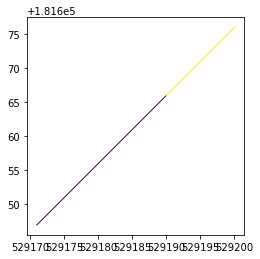

In [286]:
tt.plot()

In [287]:
for i in tt['geometry']:
    print(i)

LINESTRING (529190.0037695102 181665.9995905881, 529180.5037694939 181656.4995905887, 529171.0037694775 181646.9995905896)
LINESTRING (529200.0037695272 181675.9995905893, 529195.0037695188 181670.9995905869, 529190.0037695102 181665.9995905881)


In [92]:
s=nodes_geo[nodes_geo['x']==529824.00376860122]
s

x              y  \
1754  529824.003769  180594.999589   

                                         geometry  
1754  POINT (529824.0037686012 180594.9995892482)

In [193]:
tt = result.loc[(result['u'] ==2972) | (result['v'] ==2972) ]

In [ ]:
(529190.0037695102 181665.9995905881, 529180.5037694939 181656.4995905887, 529171.0037694775 181646.9995905896)
LINESTRING (529200.0037695272 181675.9995905893, 529195.0037695188 181670.9995905869, 529190.0037695102 181665.9995905881)

In [25]:
lineA = ((529171.00376947752, 181646.9995905896), (529190.003769510222, 181665.999590588122))
lineB = ((529190.003769510222, 181665.999590588122), (529200.0037695272, 181675.9995905893))
ang(lineA, lineB)

0.0

# NetworkX

In [337]:
pos = {}

for i in range(0,len(Gc.nodes(1))):
        coor = (Gc.nodes(1)[i][1]['x'],Gc.nodes(1)[i][1]['y'])
        pos[i]=coor

In [338]:
Ng = nx.Graph() #Empty graph

Ng.add_nodes_from(pos.keys()) #Add nodes preserving coordinates

In [339]:
for i in range(0,len(Ng.nodes())):
    Ng.node[i]['x']=pos[i][0]
    Ng.node[i]['y']=pos[i][1]

In [340]:
for i in list(Gc.edges()):
    Ng.add_edge(i[0], i[1])

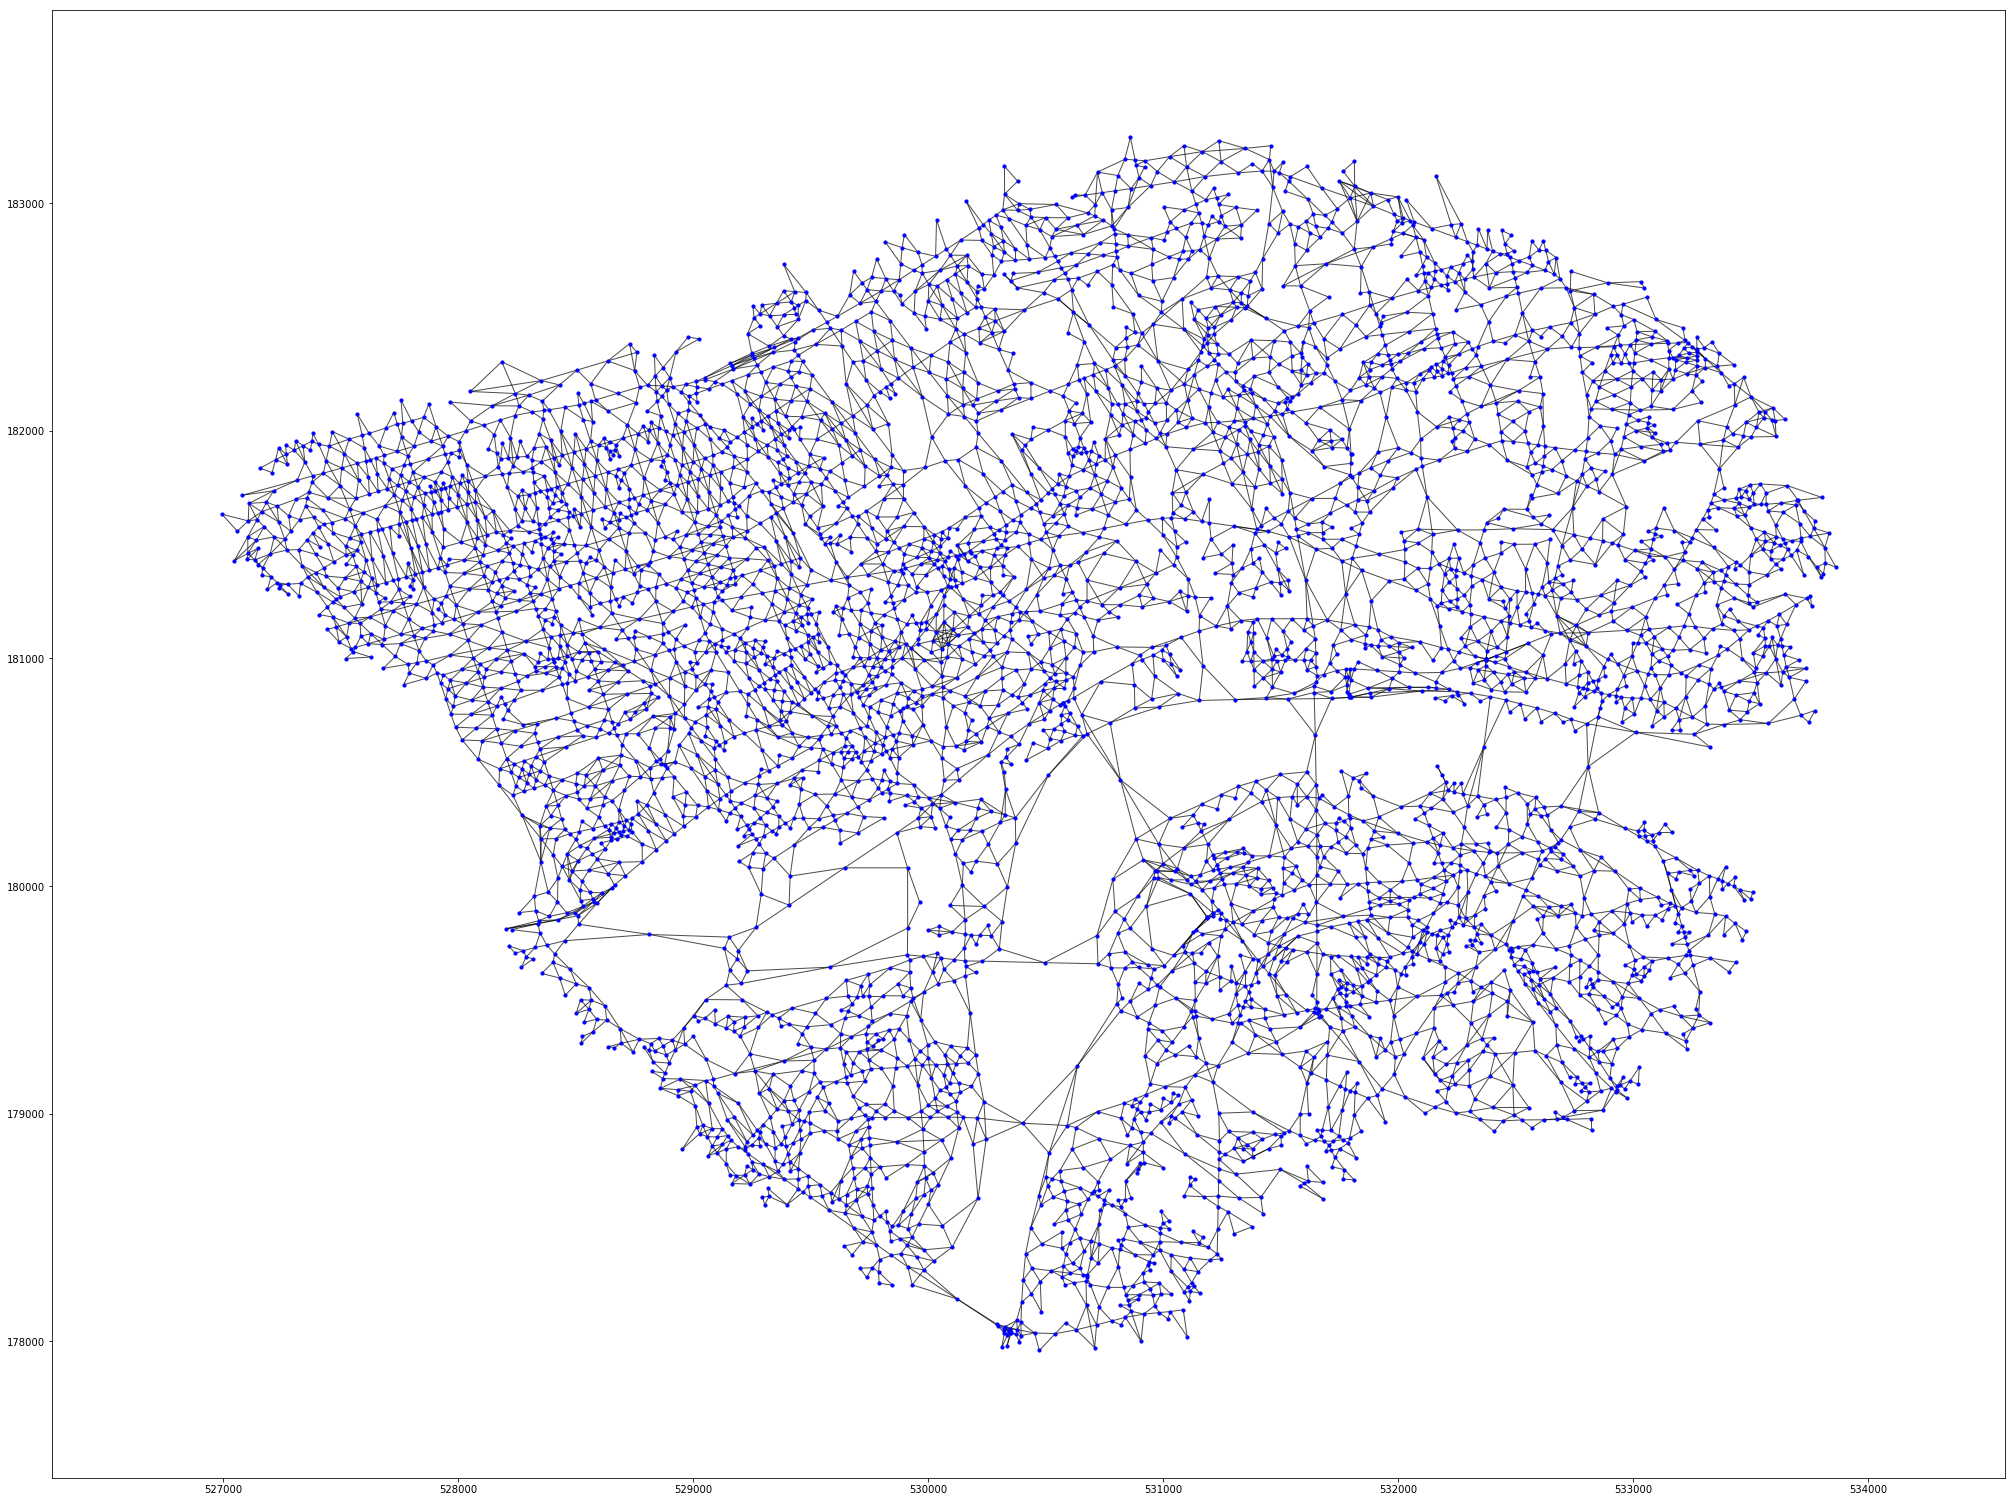

In [341]:
plt.figure(figsize=(35,27))
nx.draw_networkx_nodes(Gc,pos,node_size=10,node_color='b')
nx.draw_networkx_edges(Gc,pos, alpha=0.7)

In [336]:
len(Ng.edges())

11426

In [330]:
Gn = Gn.to_undirected()

NameError: name 'Gn' is not defined

In [331]:
L = nx.line_graph(Ng)

In [334]:
partition = community.best_partition(L)

In [335]:
partition

{(650, 3841): 0,
 (3838, 3841): 0,
 (4256, 4264): 1,
 (4264, 5375): 1,
 (2576, 2578): 2,
 (2578, 2579): 2,
 (4388, 4392): 3,
 (4392, 4394): 3,
 (476, 2601): 4,
 (2592, 2601): 4,
 (2852, 2853): 5,
 (2853, 2856): 5,
 (3598, 3678): 6,
 (3669, 3678): 6,
 (1932, 1933): 7,
 (1933, 1936): 7,
 (2923, 2925): 8,
 (2925, 3080): 8,
 (2292, 2295): 9,
 (2295, 2302): 9,
 (3213, 3217): 10,
 (3217, 3361): 10,
 (1448, 1449): 9,
 (1449, 1451): 9,
 (1712, 1760): 11,
 (1760, 1770): 11,
 (1544, 1546): 12,
 (1544, 4721): 12,
 (4868, 5098): 13,
 (4868, 5101): 13,
 (946, 948): 14,
 (946, 951): 14,
 (2474, 2528): 15,
 (2528, 2531): 15,
 (1886, 2697): 16,
 (1889, 2697): 16,
 (205, 4635): 12,
 (205, 4636): 12,
 (179, 1371): 9,
 (180, 1371): 9,
 (4691, 4788): 17,
 (4781, 4788): 17,
 (3511, 3513): 18,
 (3511, 3542): 18,
 (2157, 2158): 19,
 (2158, 2161): 19,
 (961, 962): 14,
 (962, 963): 20,
 (2086, 2140): 7,
 (2086, 2142): 7,
 (267, 306): 21,
 (305, 306): 21,
 (3045, 3047): 10,
 (3047, 3055): 10,
 (3668, 3671): 22,

In [267]:
import pylab
import random

n=(max(partition.values()))+1
cm = pylab.get_cmap('nipy_spectral')

In [268]:
cgen = list(cm(1.*i/n) for i in range(n))

In [269]:
random.shuffle(cgen)

In [270]:
nx.set_edge_attributes(Ng, 'partition', partition)

TypeError: 'int' object is not iterable

In [594]:
for u,v,d in Gn.edges(data=True):
    d['color']=cgen[d['partition']]

In [596]:
colors = [Gn[u][v]['color'] for u,v in edges]
part = [Gn[u][v]['partition'] for u,v in edges]

C:\Users\gabri\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\gabri\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\gabri\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\gabri\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

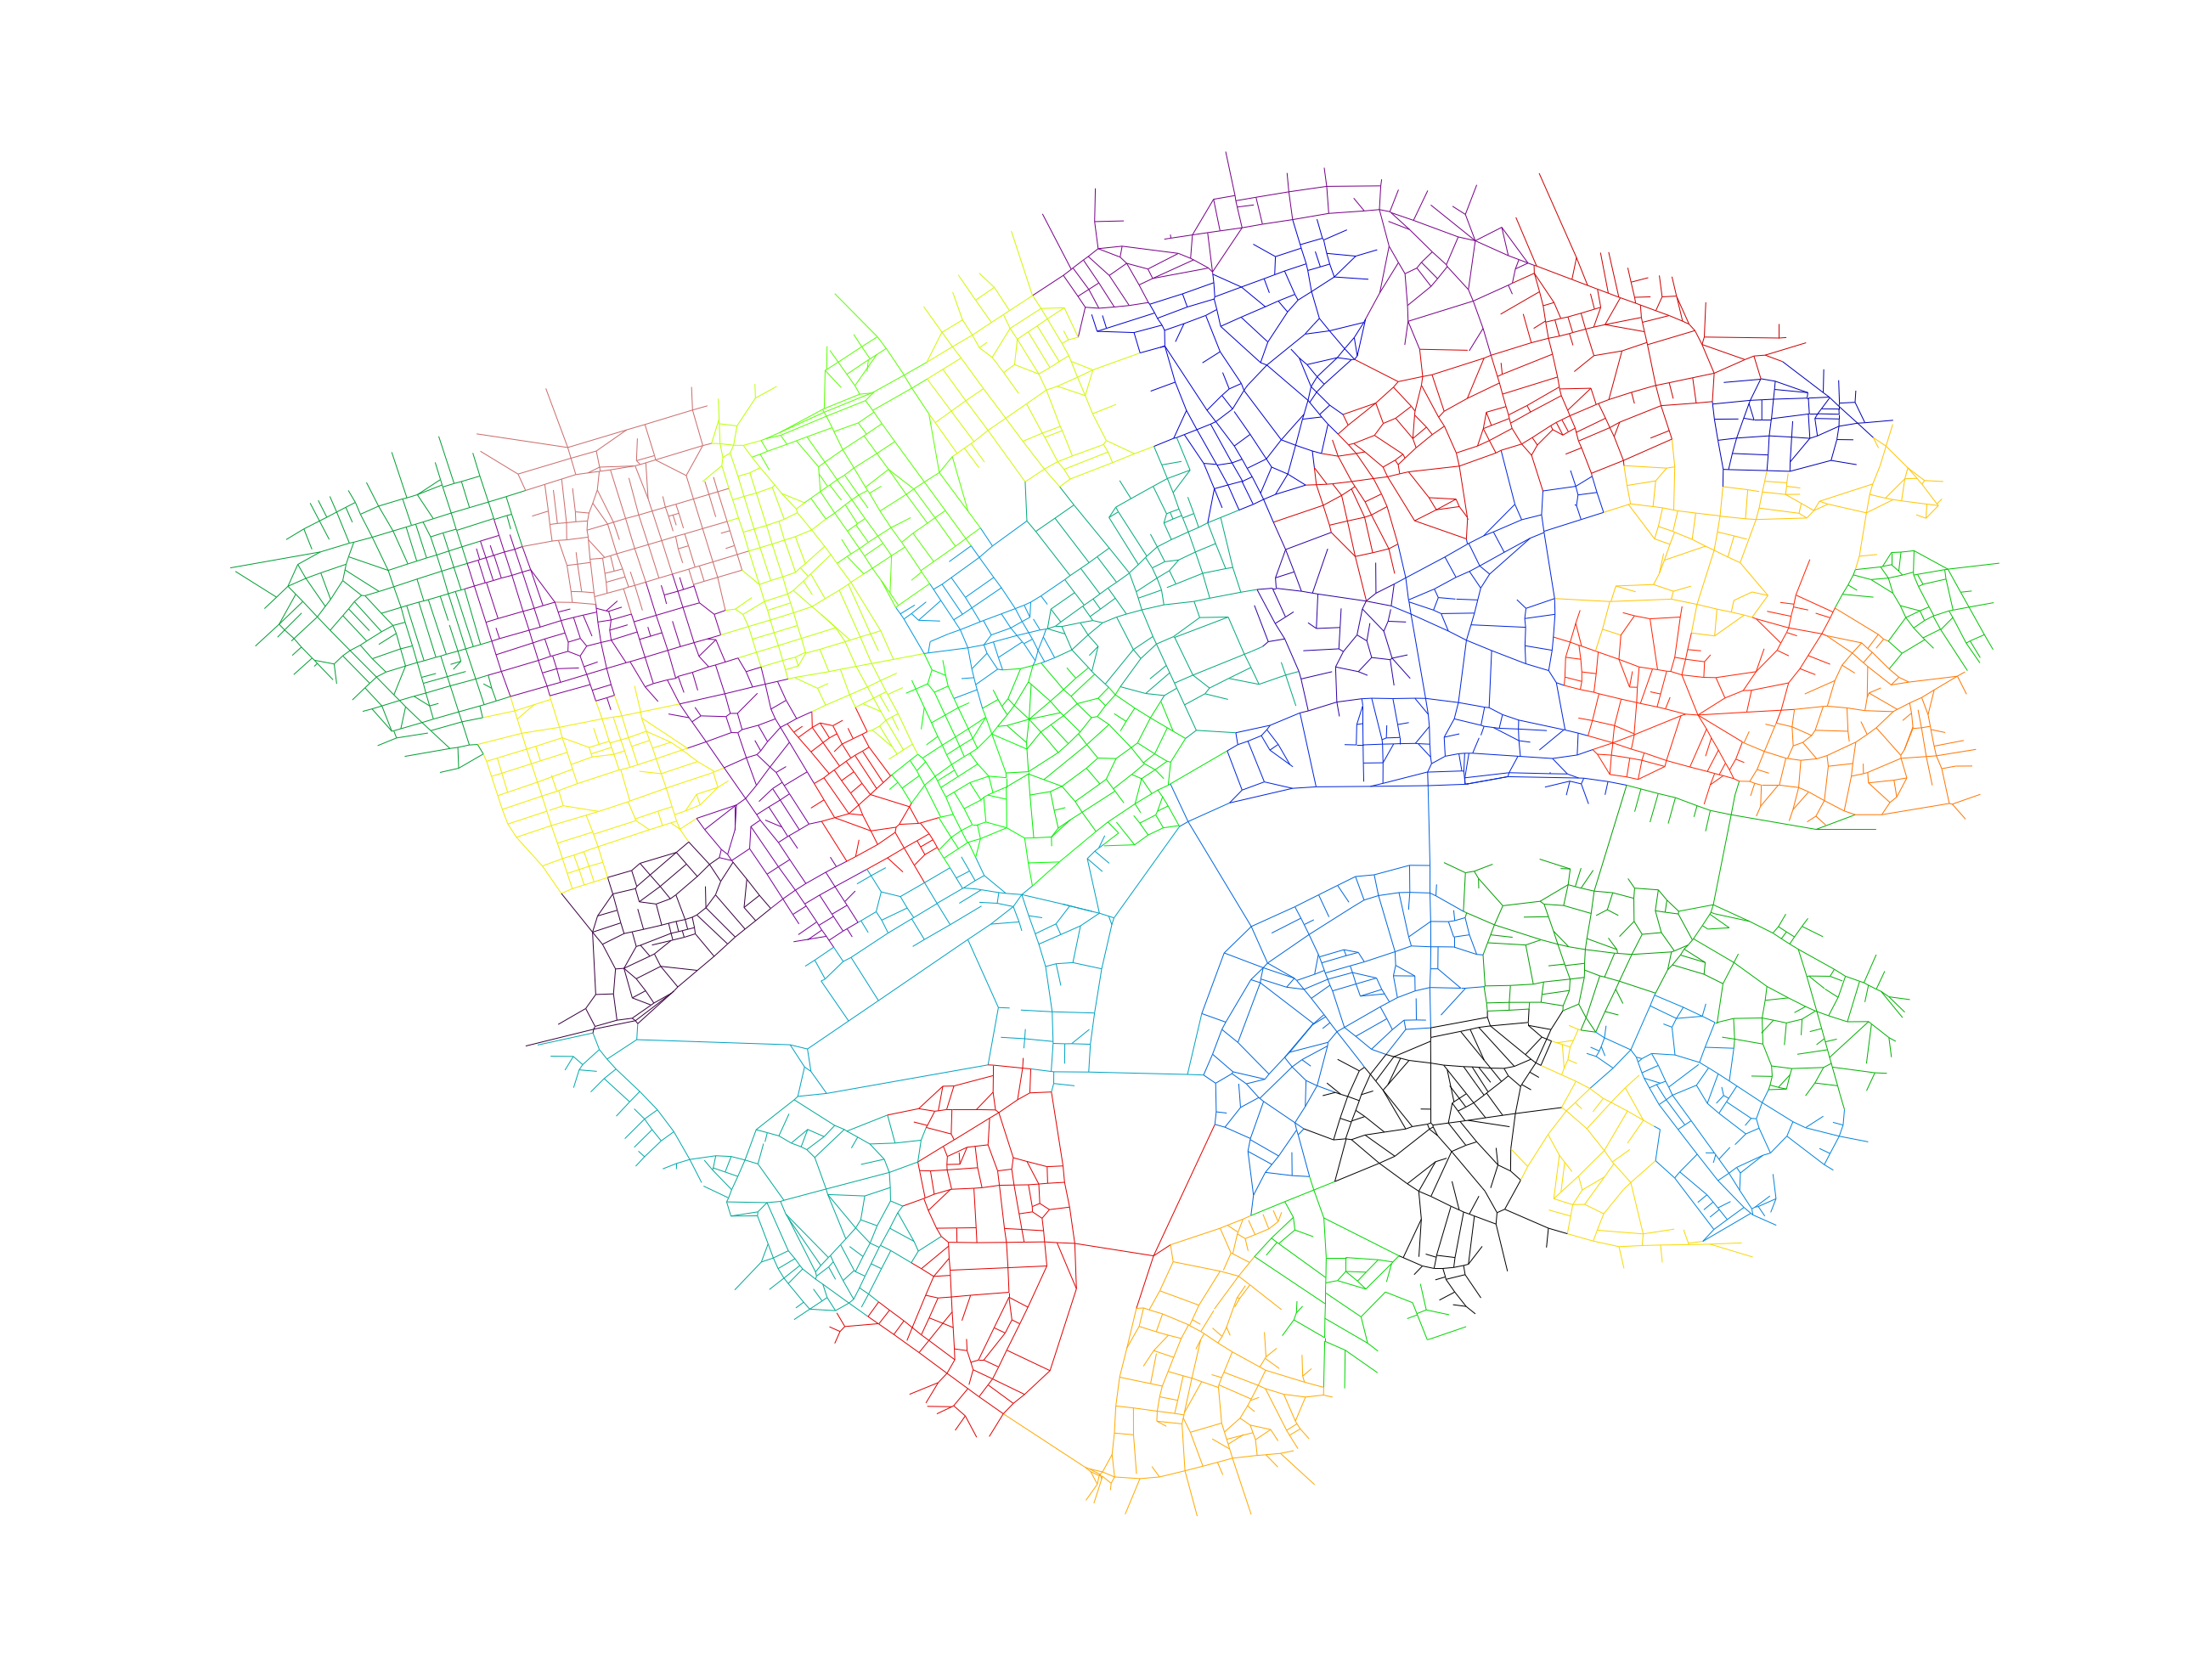

In [597]:
plt.figure(figsize=(35,27))
nx.draw(Gn,pos,alpha=1, node_size=0,edge_color=colors)

# Buffered

In [ ]:
def clean_intersections_short(G, tolerance, dead_ends=False):

    # if dead_ends is False, discard dead-end nodes to only work with edge intersections
    if not dead_ends:
        if 'streets_per_node' in G.graph:
            streets_per_node = G.graph['streets_per_node']
        else:
            streets_per_node = count_streets_per_node(G)

        dead_end_nodes = [node for node, count in streets_per_node.items() if count <= 1]
        G = G.copy()
        G.remove_nodes_from(dead_end_nodes)

    # create a GeoDataFrame of nodes, buffer to passed-in distance, merge overlaps
    gdf_nodes = ox.graph_to_gdfs(G, edges=False)
    buffered_nodes = gdf_nodes.buffer(tolerance).unary_union
    if isinstance(buffered_nodes, Polygon):
        # if only a single node results, make it iterable so we can turn it into a GeoSeries
        buffered_nodes = [buffered_nodes]

    # get the centroids of the merged intersection polygons
    unified_intersections = gpd.GeoSeries(list(buffered_nodes))
    #intersection_centroids = unified_intersections.centroid
    return unified_intersections

In [ ]:
buffered_nodes = clean_intersections_short(G_projected, tolerance=15, dead_ends=False)
centroids = ox.clean_intersections(G_projected, tolerance=15, dead_ends=False)

In [ ]:
p = []

for points in centroids:
    t = mapping(points)
    p.append(t)
    
centroid_list = []
for points in p:
    centroid_list.append(points['coordinates'])
    


In [ ]:
buffered_intersections

In [ ]:
for polygon in buffered_intersections:
    t = mapping(polygon)

In [ ]:
t

In [ ]:
a = []

for polygon in buffered_intersections:
    t = mapping(polygon)
    a.append(t)

coord = []
for polygon in a:
    coord.append(polygon['coordinates'])
    
groups = []
for f in range(0,len(coord)):
    l = coord[f]
    groups.append(list(l[0]))

In [ ]:
temp = {}
old_nodes = []
coor = []
for i in range(0, len(nodes_list)):
    cod = nodes_list[i][0]
    x = nodes_list[i][1]['x']
    y = nodes_list[i][1]['y']
    temp = {cod: (x,y)}
    c = (x,y)
    old_nodes.append(temp)
    coor.append(c)